In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import random
import pickle
import os
from scipy import ndimage
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras

# Spracovanie dát

## Ukážka dát

In [2]:
data_path = '/Users/kuko/Desktop/projekt/BraTS2021'

print(os.listdir(data_path))

training_path = os.path.join(data_path, 'train/')
testing_path = os.path.join(data_path, 'test/')
validation_path = os.path.join(data_path, 'val/')

['.DS_Store', 'test', 'train', 'val']


Tu len randomne vyberá časti, aby ukázal, že tam je veľa zbytočného

/Users/kuko/Desktop/projekt/BraTS2021/train/BraTS2021_00002/BraTS2021_00002_t1ce.nii.gz
[0. 1.]


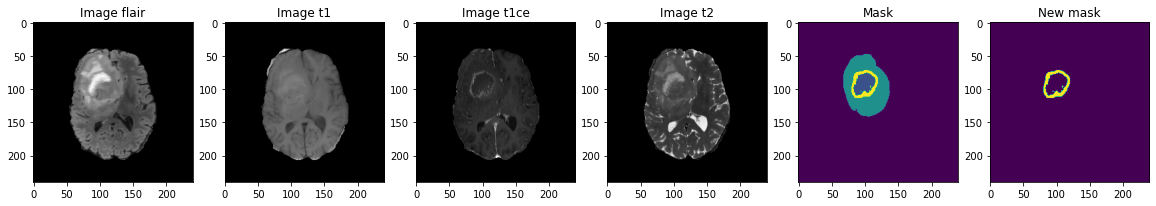

In [3]:
test_image_t1ce=nib.load(training_path + 'BraTS2021_00002/BraTS2021_00002_t1ce.nii.gz').get_fdata()
test_image_t1=nib.load(training_path + 'BraTS2021_00002/BraTS2021_00002_t1.nii.gz').get_fdata()
test_image_flair=nib.load(training_path + 'BraTS2021_00002/BraTS2021_00002_flair.nii.gz').get_fdata()
test_image_t2=nib.load(training_path + 'BraTS2021_00002/BraTS2021_00002_t2.nii.gz').get_fdata()
test_mask=nib.load(training_path + 'BraTS2021_00002/BraTS2021_00002_seg.nii.gz').get_fdata()

print(training_path + 'BraTS2021_00002/BraTS2021_00002_t1ce.nii.gz')

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6, figsize = (20, 10))
ax1.imshow(ndimage.rotate(test_image_flair[:,:,80], 270), cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(ndimage.rotate(test_image_t1[:,:,80], 270), cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(ndimage.rotate(test_image_t1ce[:,:,80], 270), cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(ndimage.rotate(test_image_t2[:,:,80], 270), cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(ndimage.rotate(test_mask[:,:,80], 270))
ax5.set_title('Mask')

test_mask[test_mask==4] = 3

test_mask[test_mask==1] = 0
test_mask[test_mask==2] = 0
test_mask[test_mask==3] = 1
print(np.unique(test_mask))

ax6.imshow(ndimage.rotate(test_mask[:,:,80], 270))
ax6.set_title('New mask')
plt.show()

# Data generator

In [5]:
from tensorflow import keras
import numpy as np
import nibabel as nib

# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class BratsGen(keras.utils.Sequence):
    def __init__(self, flair_list, t1ce_list, t2_list, mask_list, img_dim=(128,128,128),
                 img_channels=3, classes=4, batch_size=2, segmenting_subregion=0):
        self.batch_size = batch_size
        self.classes = classes
        self.img_channels = img_channels
        self.img_dim = img_dim
        self.flair_list = flair_list
        self.t1ce_list = t1ce_list
        self.t2_list = t2_list
        self.mask_list = mask_list
        self.segmenting_subregion = segmenting_subregion

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_flair = self.flair_list[i : i + self.batch_size]
        batch_t1ce = self.t1ce_list[i : i + self.batch_size]
        batch_t2 = self.t2_list[i : i + self.batch_size]
        batch_mask = self.mask_list[i : i + self.batch_size]

        X, y = self.__data_generation(batch_flair, batch_t1ce, batch_t2, batch_mask)

        return X, y

    def __data_generation(self, flair_list, t1ce_list, t2_list, mask_list):
        #X = np.zeros((self.batch_size*self.img_dim[2], self.img_dim[0], self.img_dim[1], self.img_channels))
        #y = np.zeros((self.batch_size*self.img_dim[2], self.img_dim[0], self.img_dim[1]))
        #Y = np.zeros((self.batch_size*self.img_dim[2], self.img_dim[0], self.img_dim[1], 4))

        images = []
        masks = []
        for flair_name, t1ce_name, t2_name, mask_name in zip(flair_list, t1ce_list, t2_list, mask_list):
            flair = nib.load(flair_name).get_fdata()
            t1ce = nib.load(t1ce_name).get_fdata()
            t2 = nib.load(t2_name).get_fdata()
            mask = nib.load(mask_name).get_fdata()

            image = np.stack([flair, t1ce, t2], axis=3)
            image = image[56:184, 56:184, 13:141]

            # label 3 is empty
            mask[mask == 4] = 3
            # segmenting label 1
            if self.segmenting_subregion == 1:
                mask[mask == 2] = 0
                mask[mask == 3] = 0
            # segmenting label 2
            elif self.segmenting_subregion == 2:
                mask[mask == 1] = 0
                mask[mask == 3] = 0
                mask[mask == 2] = 1
            # segmenting label 3
            elif self.segmenting_subregion == 3:
                mask[mask == 1] = 0
                mask[mask == 2] = 0
                mask[mask == 3] = 1

            mask = mask[56:184, 56:184, 13:141]
            if self.segmenting_subregion == 0:
                mask = to_categorical(mask, num_classes=4)
            else:
                mask = to_categorical(mask, num_classes=2)

            images.append(image)
            masks.append(mask)

            #X[j+(VOLUME_SLICES*c),:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
            #X[j+(VOLUME_SLICES*c),:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
            #y[j +VOLUME_SLICES*c,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        images = np.array(images)
        masks = np.array(masks)

        return images/np.max(images), masks

na načítanie dát/obrázkov,

ten data generátor, čo je v keras pracuje len s obrázkami (.png, .jpeg, ...)

In [7]:
def load_img(flair_list, t1ce_list, t2_list):
    scaler = MinMaxScaler()
    images = []
    for flair_name, t1ce_name, t2_name in zip(flair_list, t1ce_list, t2_list):
        temp_image_flair = nib.load(flair_name).get_fdata()
        # print(np.max(temp_image_flair))
        temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(
            temp_image_flair.shape)
        # print("========================================")
        # print(np.max(temp_image_flair))
        temp_image_t1ce = nib.load(t1ce_name).get_fdata()
        temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(
            temp_image_t1ce.shape)

        temp_image_t2 = nib.load(t2_name).get_fdata()
        temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(
            temp_image_t2.shape)

        image = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
        image = image[56:184, 56:184, 13:141]

        images.append(image)

    images = np.array(images)

    return images

In [8]:
def load_mask(mask_list, segmenting_subregion=0):
    images = []
    for mask_name in mask_list:
        temp_mask = nib.load(mask_name).get_fdata()
        temp_mask = temp_mask.astype(np.uint8)
        temp_mask[temp_mask == 4] = 3  # Reassign mask values 4 to 3

        # segmenting label 1
        if segmenting_subregion == 1:
            temp_mask[temp_mask == 2] = 0
            temp_mask[temp_mask == 3] = 0
        # segmenting label 2
        elif segmenting_subregion == 2:
            temp_mask[temp_mask == 1] = 0
            temp_mask[temp_mask == 3] = 0
            temp_mask[temp_mask == 2] = 1
        # segmenting label 3
        elif segmenting_subregion == 3:
            temp_mask[temp_mask == 1] = 0
            temp_mask[temp_mask == 2] = 0
            temp_mask[temp_mask == 3] = 1

        image = temp_mask[56:184, 56:184, 13:141]
        # print(np.unique(temp_mask))

        if segmenting_subregion == 0:
            image = to_categorical(image, num_classes=4)
        else:
            image = to_categorical(image, num_classes=2)

        images.append(image)

    images = np.array(images)

    return images

In [9]:
def image_loader(flair_list, t1ce_list, t2_list, mask_list, batch_size, segmenting_subregion):
    img_len = len(flair_list)

    # keras needs the generator infinite
    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_start < img_len:
            limit = min(batch_end, img_len)
            x = load_img(flair_list[batch_start:limit], t1ce_list[batch_start:limit], t2_list[batch_start:limit])
            y = load_mask(mask_list[batch_start:limit], segmenting_subregion)

            yield (x, y)  # a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size

### Testovanie generátora

In [6]:
t2_list = sorted(glob.glob(training_path + '/*/*t2.nii.gz'))
t1ce_list = sorted(glob.glob(training_path + '/*/*t1ce.nii.gz'))
flair_list = sorted(glob.glob(training_path + '/*/*flair.nii.gz'))
mask_list = sorted(glob.glob(training_path + '/*/*seg.nii.gz'))

print(t2_list)

['/Users/kuko/Desktop/projekt/BraTS2021/train/BraTS2021_00002/BraTS2021_00002_t2.nii.gz', '/Users/kuko/Desktop/projekt/BraTS2021/train/BraTS2021_00003/BraTS2021_00003_t2.nii.gz', '/Users/kuko/Desktop/projekt/BraTS2021/train/BraTS2021_00005/BraTS2021_00005_t2.nii.gz', '/Users/kuko/Desktop/projekt/BraTS2021/train/BraTS2021_00008/BraTS2021_00008_t2.nii.gz', '/Users/kuko/Desktop/projekt/BraTS2021/train/BraTS2021_00009/BraTS2021_00009_t2.nii.gz', '/Users/kuko/Desktop/projekt/BraTS2021/train/BraTS2021_00011/BraTS2021_00011_t2.nii.gz', '/Users/kuko/Desktop/projekt/BraTS2021/train/BraTS2021_00012/BraTS2021_00012_t2.nii.gz', '/Users/kuko/Desktop/projekt/BraTS2021/train/BraTS2021_00014/BraTS2021_00014_t2.nii.gz', '/Users/kuko/Desktop/projekt/BraTS2021/train/BraTS2021_00016/BraTS2021_00016_t2.nii.gz', '/Users/kuko/Desktop/projekt/BraTS2021/train/BraTS2021_00017/BraTS2021_00017_t2.nii.gz', '/Users/kuko/Desktop/projekt/BraTS2021/train/BraTS2021_00021/BraTS2021_00021_t2.nii.gz', '/Users/kuko/Desktop

(128, 128, 128)


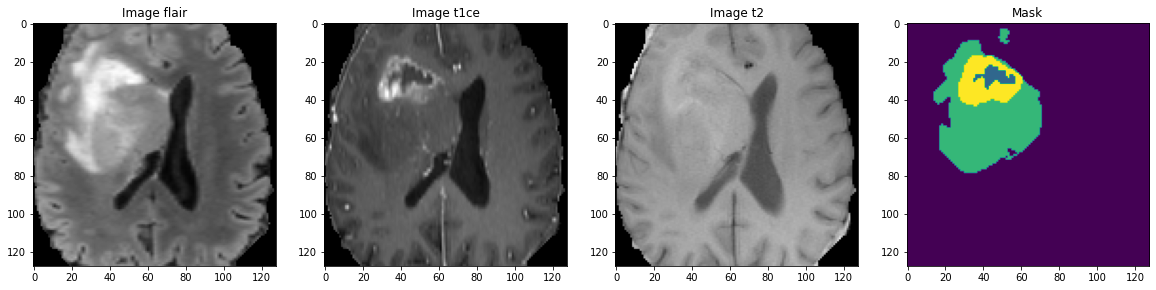

In [14]:
#train_generator = BratsGen(flair_list, t1ce_list, t2_list, mask_list)
train_generator = BratsGen([training_path + 'BraTS2021_00002/BraTS2021_00002_flair.nii.gz'],
                           [training_path + 'BraTS2021_00002/BraTS2021_00002_t1ce.nii.gz'],
                           [training_path + 'BraTS2021_00002/BraTS2021_00002_t1.nii.gz'],
                           [training_path + 'BraTS2021_00002/BraTS2021_00002_seg.nii.gz'],
                           segmenting_subregion=0)
img, mask = train_generator.__getitem__(0)
mask = np.argmax(mask[0], axis=-1)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 10))
ax1.imshow(ndimage.rotate(img[0][:,:,80,0], 270), cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(ndimage.rotate(img[0][:,:,80,1], 270), cmap = 'gray')
ax2.set_title('Image t1ce')
ax3.imshow(ndimage.rotate(img[0][:,:,80,2], 270), cmap = 'gray')
ax3.set_title('Image t2')
ax4.imshow(ndimage.rotate(mask[:,:,80], 270))
ax4.set_title('Mask')
plt.show()

[0. 1.]
[0 1 2 3]
[[[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  ...

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]


 [[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0

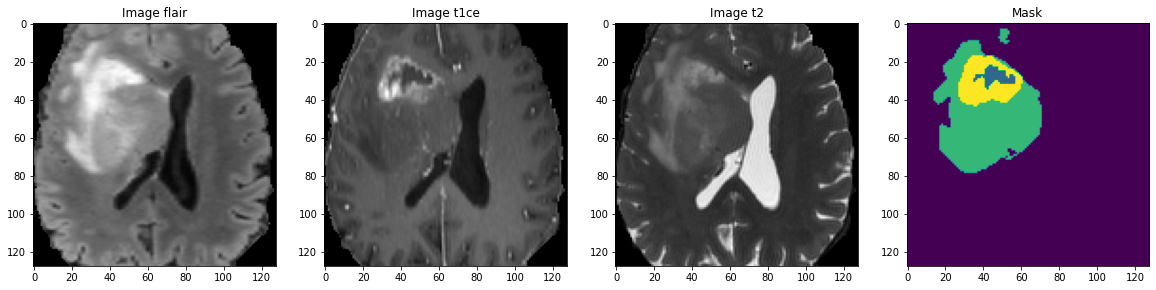

In [44]:
img_datagen = image_loader(flair_list, t1ce_list, t2_list, mask_list, 2,
                                       segmenting_subregion=0)
img, mask = img_datagen.__next__()
print(np.unique(mask))
mask = np.argmax(mask, axis=4)
print(np.unique(mask))
print(mask)

#print(mask_list[:1])
#print(flair_list[:1])
print(img.shape)
print(mask.shape)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 10))
ax1.imshow(ndimage.rotate(img[0][:,:,80,0], 270), cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(ndimage.rotate(img[0][:,:,80,1], 270), cmap = 'gray')
ax2.set_title('Image t1ce')
ax3.imshow(ndimage.rotate(img[0][:,:,80,2], 270), cmap = 'gray')
ax3.set_title('Image t2')
ax4.imshow(ndimage.rotate(mask[0][:,:,80], 270))
ax4.set_title('Mask')
plt.show()

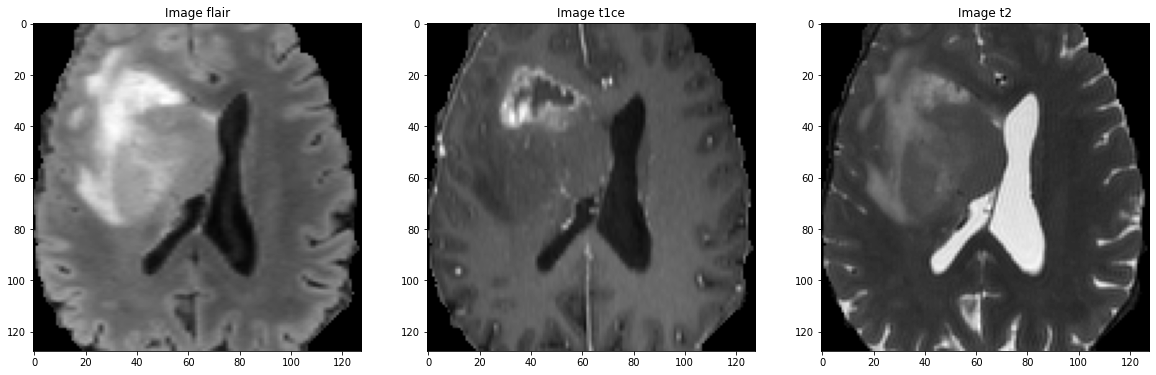

In [39]:
test_img = load_img([training_path + 'BraTS2021_00002/BraTS2021_00002_flair.nii.gz'],
                              [training_path + 'BraTS2021_00002/BraTS2021_00002_t1ce.nii.gz'],
                              [training_path + 'BraTS2021_00002/BraTS2021_00002_t1.nii.gz'])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(ndimage.rotate(img[0][:,:,80,0], 270), cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(ndimage.rotate(img[0][:,:,80,1], 270), cmap = 'gray')
ax2.set_title('Image t1ce')
ax3.imshow(ndimage.rotate(img[0][:,:,80,2], 270), cmap = 'gray')
ax3.set_title('Image t2')
plt.show()

/Users/kuko/Desktop/projekt/BraTS2021/train/BraTS2021_00639/BraTS2021_00639_flair.nii.gz
/Users/kuko/Desktop/projekt/BraTS2021/train/BraTS2021_01149/BraTS2021_01149_flair.nii.gz
/Users/kuko/Desktop/projekt/BraTS2021/train/BraTS2021_01344/BraTS2021_01344_flair.nii.gz
/Users/kuko/Desktop/projekt/BraTS2021/train/BraTS2021_00296/BraTS2021_00296_flair.nii.gz


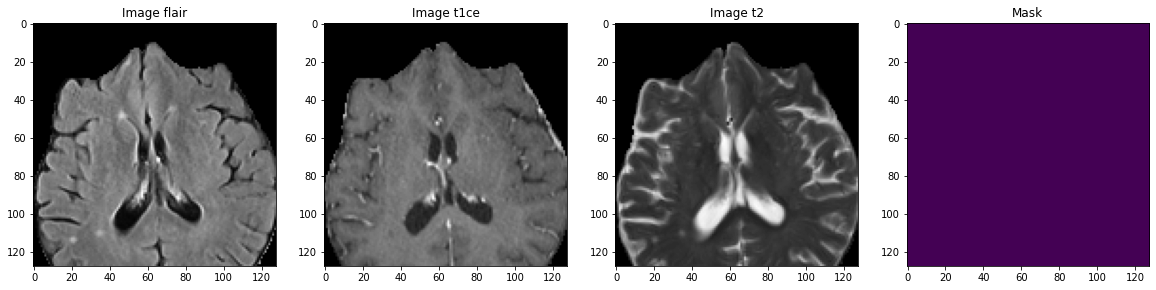

(128, 128, 128)

In [12]:
batch_size = 4

train_img_datagen = imageLoader(flair_list, t1ce_list, t2_list, mask_list, batch_size)

img, msk = train_img_datagen.__next__()


#img_num = random.randint(0,img.shape[0]-1)
img_num = 2
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

#n_slice=random.randint(0, test_mask.shape[2])
n_slice = 70

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 10))
ax1.imshow(ndimage.rotate(test_img[:,:,n_slice,0], 270), cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(ndimage.rotate(test_img[:,:,n_slice,1], 270), cmap = 'gray')
ax2.set_title('Image t1ce')
ax3.imshow(ndimage.rotate(test_img[:,:,n_slice,2], 270), cmap = 'gray')
ax3.set_title('Image t2')
ax4.imshow(ndimage.rotate(test_mask[:,:,n_slice], 270))
ax4.set_title('Mask')
plt.show()

test_mask.shape

# Model

## Definovanie modelu

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU


kernel_initializer = 'he_uniform' # Try others if you want

def unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
  #s = Lambda(lambda x: x / 255)(inputs)   # No need for this if we normalize our inputs beforehand
  s = inputs

  # Contraction path
  c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
  c1 = Dropout(0.1)(c1)
  c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
  p1 = MaxPooling3D((2, 2, 2))(c1)

  c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
  c2 = Dropout(0.1)(c2)
  c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
  p2 = MaxPooling3D((2, 2, 2))(c2)

  c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
  p3 = MaxPooling3D((2, 2, 2))(c3)

  c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
  p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

  c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

  # Expansive path
  u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

  u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

  u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
  c8 = Dropout(0.1)(c8)
  c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

  u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1])
  c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
  c9 = Dropout(0.1)(c9)
  c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

  outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  model.summary()

  return model

model = unet_model(128, 128, 128, 3, 4)
print("input shape: ", model.input_shape)
print("output shape: ", model.output_shape)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_19 (Conv3D)             (None, 128, 128, 12  1312        ['input_2[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 12  0           ['conv3d_19[0][0]']              
                                8, 16)                                                      

Definovanie tých generátorov pre **trénovanie** a **validáciu**

In [ ]:
train_t2_list = glob.glob(training_path + '/*/*t2.nii.gz')
train_t1ce_list = glob.glob(training_path + '/*/*t1ce.nii.gz')
train_flair_list = glob.glob(training_path + '/*/*flair.nii.gz')
train_mask_list = glob.glob(training_path + '/*/*seg.nii.gz')

val_t2_list = glob.glob(validation_path + '/*/*t2.nii.gz')
val_t1ce_list = glob.glob(validation_path + '/*/*t1ce.nii.gz')
val_flair_list = glob.glob(validation_path + '/*/*flair.nii.gz')
val_mask_list = glob.glob(validation_path + '/*/*seg.nii.gz')

print(train_t2_list)

['BraTS2021_Training/BraTS2021_01453/BraTS2021_01453_t2.nii.gz', 'BraTS2021_Training/BraTS2021_01442/BraTS2021_01442_t2.nii.gz', 'BraTS2021_Training/BraTS2021_01452/BraTS2021_01452_t2.nii.gz', 'BraTS2021_Training/BraTS2021_01451/BraTS2021_01451_t2.nii.gz', 'BraTS2021_Training/BraTS2021_01443/BraTS2021_01443_t2.nii.gz', 'BraTS2021_Training/BraTS2021_01449/BraTS2021_01449_t2.nii.gz', 'BraTS2021_Training/BraTS2021_01440/BraTS2021_01440_t2.nii.gz', 'BraTS2021_Training/BraTS2021_01448/BraTS2021_01448_t2.nii.gz', 'BraTS2021_Training/BraTS2021_01445/BraTS2021_01445_t2.nii.gz', 'BraTS2021_Training/BraTS2021_01446/BraTS2021_01446_t2.nii.gz', 'BraTS2021_Training/BraTS2021_01447/BraTS2021_01447_t2.nii.gz', 'BraTS2021_Training/BraTS2021_01439/BraTS2021_01439_t2.nii.gz', 'BraTS2021_Training/BraTS2021_01438/BraTS2021_01438_t2.nii.gz', 'BraTS2021_Training/BraTS2021_01441/BraTS2021_01441_t2.nii.gz', 'BraTS2021_Training/BraTS2021_01450/BraTS2021_01450_t2.nii.gz', 'BraTS2021_Training/BraTS2021_01444/Bra

Definovanie batch size a data generátora

In [ ]:
batch_size = 2

train_img_datagen = imageLoader(train_flair_list, train_t1ce_list, train_t2_list, train_mask_list, batch_size)
val_img_datagen = imageLoader(val_flair_list, val_t1ce_list, val_t2_list, val_mask_list, batch_size)

Znovu testovanie

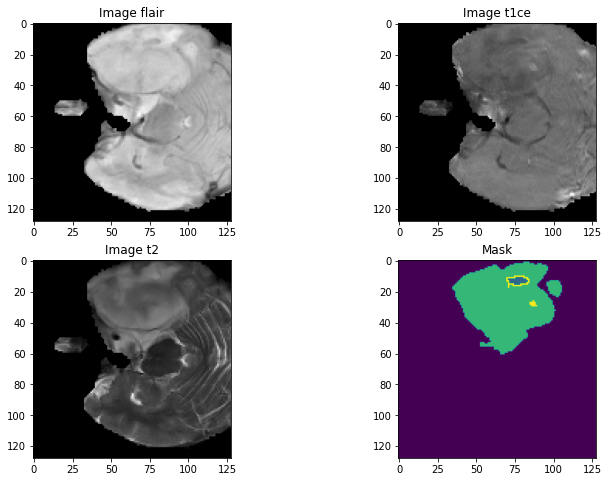

In [ ]:
img, msk = val_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 10))
ax1.imshow(ndimage.rotate(test_img[:,:,n_slice,0], 270), cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(ndimage.rotate(test_img[:,:,n_slice,1], 270), cmap = 'gray')
ax2.set_title('Image t1ce')
ax3.imshow(ndimage.rotate(test_img[:,:,n_slice,2], 270), cmap = 'gray')
ax3.set_title('Image t2')
ax4.imshow(ndimage.rotate(test_mask[:,:,n_slice], 270))
ax4.set_title('Mask')
plt.show()

In [ ]:
import keras.backend as K


"""
Dice = (2*|X & Y|)/ (|X|+ |Y|)
     =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
ref: https://arxiv.org/pdf/1606.04797v1.pdf
"""
def dice_coef(y_true, y_pred, epsilon=0.00001):
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))

# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,1] * y_pred[0,:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,1])) + K.sum(K.square(y_pred[0,:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,2] * y_pred[0,:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,2])) + K.sum(K.square(y_pred[0,:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,3] * y_pred[0,:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,3])) + K.sum(K.square(y_pred[0,:,:,:,3])) + epsilon)

Definovanie loss a optimizer

In [ ]:
#!pip install segmentation-models-3D
#!pip install keras_applications
from segmentation_models_3D import losses

# Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
dice_loss = losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)
total_loss = dice_loss

#metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), tf.keras.metrics.MeanIoU(num_classes=4),
           dice_coef, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing]

## Trénovanie

In [ ]:
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

steps_per_epoch = len(train_flair_list)//batch_size
val_steps_per_epoch = len(val_flair_list)//batch_size

model = unet_model(IMG_HEIGHT=128, IMG_WIDTH=128, IMG_DEPTH=128, IMG_CHANNELS=3, num_classes=4)
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)

#print(model.summary())
#print(model.input_shape)
#print(model.output_shape)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_57 (Conv3D)             (None, 128, 128, 12  1312        ['input_4[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_27 (Dropout)           (None, 128, 128, 12  0           ['conv3d_57[0][0]']              
                                8, 16)                                                      

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

Callback

In [ ]:
from keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

csv_logger = CSVLogger('outputs/training.log', separator=',', append=False)

callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=2, verbose=1, mode='auto'),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1),
             csv_logger]

'''
callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=2, verbose=1, mode='auto'),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1),
             keras.callbacks.ModelCheckpoint(filepath='checkpoints/model_.{epoch:02d}-{val_loss:.6f}.m5',
                                             verbose=1, save_best_only=True, save_weights_only = True),
             csv_logger]
'''

In [ ]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=30,
          verbose=1,
          callbacks=callbacks,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch)

model.save('outputs/brats_3d.h5')

with open('outputs/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-46-a419f2ae3179>", line 7, in <module>
    validation_steps=val_steps_per_epoch)
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/data_adapter.py", line 859, in _peek_and_restore
    peek = next(x)
StopIteration

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'StopIteration' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Trace

StopIteration: ignored

## Záver z trénovania

## Trenovanie ešte raz

In [30]:
import segmentation_models_3D as sm
my_model = tf.keras.models.load_model('../brats_3d_2ch.h5', custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                                         'dice_loss': dice_loss, 
                                                         'iou_score': sm.metrics.IOUScore(threshold=0.5),
                                                         'dice_coef': dice_coef,
                                                         'dice_coef_necrotic': dice_coef_necrotic,
                                                         'dice_coef_edema': dice_coef_edema,
                                                         'dice_coef_enhancing': dice_coef_enhancing
                                                         })

ModuleNotFoundError: No module named 'keras_applications'

In [ ]:
history=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=5,
          verbose=1,
          callbacks=callbacks,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch)

model.save('brats_3d.h5')

NameError: ignored

In [ ]:
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.4409805


In [ ]:
dice_coef(test_mask_batch_argmax, test_pred_batch_argmax)

TypeError: ignored

In [ ]:
results = my_model.evaluate(test_img_datagen, callbacks= callbacks)

    387/Unknown - 4052s 10s/step - loss: 0.8640 - accuracy: 0.9635 - iou_score: 0.4759 - mean_io_u: 0.4188 - dice_coef: 0.6311 - dice_coef_necrotic: 0.2169 - dice_coef_edema: 0.6297 - dice_coef_enhancing: 0.3571

KeyboardInterrupt: ignored

In [ ]:
import keras.backend as K

def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[0,:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[0,:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[0,:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[0,:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[0,:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[0,:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[0,:,:,:,3])) + epsilon)


In [ ]:
import re

def model_eval(img_list, mask_list):
  dice_list = list()
  necrotic_list = list()
  edema_list = list()
  enhancing_list = list()

  for i in range(len(mask_list)):
    test_img = np.load(img_list[i])
    test_mask = np.load(mask_list[i])
    test_mask_argmax=np.argmax(test_mask, axis=3)

    test_img_input = np.expand_dims(test_img, axis=0)
    test_prediction = my_model.predict(test_img_input)
    test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

    dice_list.append(dice_coef(test_mask, test_prediction).numpy())
    necrotic_list.append(dice_coef_necrotic(test_mask, test_prediction).numpy())
    edema_list.append(dice_coef_edema(test_mask, test_prediction).numpy())
    enhancing_list.append(dice_coef_enhancing(test_mask, test_prediction).numpy())

    m = re.search('/image_(.+?).npy', img_list[i])
    print(f"obrazok: {m.group(1)}")
    print(f"dice_coef: {dice_list[i]} | necrotic: {necrotic_list[i]} | edema: {edema_list[i]} | enhancing: {enhancing_list[i]}")
  
  print(f"\ndice_mean: {np.mean(dice_list)} | necrotic_mean: {np.mean(necrotic_list)} | edema_mean: {np.mean(edema_list)} | enhancing_mean: {np.mean(enhancing_list)}")
  
  worst = np.argsort(dice_list)[:5]
  print("\n5 najhorsich:")
  for i in worst:
    m = re.search('/image_(.+?).npy', img_list[i])
    print(f"obrazok: {m.group(1)}, dice = {dice_list[i]}")

  best = np.argsort(dice_list)[-5:]
  print("\n5 najlepsich:")
  for i in best:
    m = re.search('/image_(.+?).npy', img_list[i])
    print(f"obrazok: {m.group(1)}, dice = {dice_list[i]}")

In [ ]:
img_dir = "skusobny2/input_data_128/val/images/"
mask_dir = "skusobny2/input_data_128/val/masks/"

img_list = glob.glob(img_dir+"*")
mask_list = glob.glob(mask_dir+"*")

In [ ]:
model_eval(img_list, mask_list)

obrazok: 10
dice_coef: 0.45956405997276306 | necrotic: 0.28612977266311646 | edema: 0.3062351644039154 | enhancing: 0.3773258924484253
obrazok: 13
dice_coef: 0.4374447166919708 | necrotic: 0.11599457263946533 | edema: 0.6946755051612854 | enhancing: 0.1201980859041214
obrazok: 14
dice_coef: 0.4893331527709961 | necrotic: 0.23494520783424377 | edema: 0.4276890456676483 | enhancing: 0.4435701072216034
obrazok: 17
dice_coef: 0.5202767252922058 | necrotic: 0.11291379481554031 | edema: 0.7766912579536438 | enhancing: 0.43925848603248596
obrazok: 23
dice_coef: 0.41086697578430176 | necrotic: 0.008660444058477879 | edema: 0.7299948334693909 | enhancing: 0.0005605514161288738
obrazok: 24
dice_coef: 0.44546201825141907 | necrotic: 0.0 | edema: 0.8522852659225464 | enhancing: 0.0032788976095616817
obrazok: 32
dice_coef: 0.6315870881080627 | necrotic: 0.14633893966674805 | edema: 0.8384608626365662 | enhancing: 0.7684392929077148
obrazok: 35
dice_coef: 0.4257975220680237 | necrotic: 0.31599152088

In [ ]:
from matplotlib import pyplot as plt

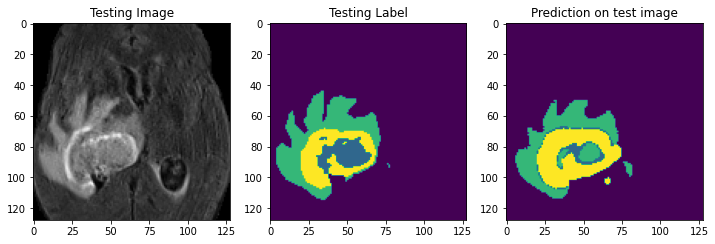

In [ ]:
img_num = 83

test_img = np.load("skusobny2/input_data_128/val/images/image_"+str(img_num)+".npy")
test_mask = np.load("skusobny2/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

n_slice = 60
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(ndimage.rotate(test_img[:,:,n_slice,0], 270), cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ndimage.rotate(test_mask_argmax[:,:,n_slice], 270))
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(ndimage.rotate(test_prediction_argmax[:,:, n_slice], 270))
plt.show()